# imports


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl
import sklearn
import seaborn as sns
import torchvision
 
from torchvision import datasets
import torchvision.transforms as transforms
 
import torch.nn as nn
import torch.nn.functional as F
 
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter




# hyper parameters


In [ ]:

# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
NUM_EPOCHS = 31
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
batch_size = 64
z_size = 5
nfeatures = 14 # just generate pca comps



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **LOAD DATA**

In [ ]:
data_path = "/content/drive/MyDrive/half_gan_work/probe_Preprocesstrain.csv"
reduced_set = pd.read_csv(data_path)
reduced_set


,Unnamed: 0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,attack
0,0,-0.261670,0.532692,0.272187,0.042320,-0.373792,-0.237265,-0.484287,-0.051673,-0.120477,-0.076283,-0.158055,-0.130387,0.063966,0.018481,normal
1,1,0.218320,1.016720,0.135702,0.066672,-0.784205,-0.072116,0.305359,0.364307,0.247091,-0.309637,0.450536,0.059455,0.348620,0.089028,normal
2,3,-1.009131,-0.607467,0.119472,-0.241722,0.284433,-0.068508,0.021614,0.122778,0.057927,0.099407,-0.007952,-0.080227,0.056512,0.009813,normal
3,4,-0.999657,-0.411611,-0.491055,0.113412,-0.069412,0.181505,0.066167,-0.129151,0.050811,-0.053955,-0.028073,0.055005,-0.027095,0.021337,normal
4,12,-1.147378,-0.427068,0.214017,-0.314900,0.224717,-0.054518,-0.032954,0.165391,0.012222,0.063960,0.054112,-0.046101,0.022750,0.007310,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78994,125965,-0.943346,0.063158,1.023034,-0.624882,-0.260899,0.129958,0.314504,-0.054927,-0.159097,-0.122380,0.294411,0.551059,-0.183774,0.014339,normal
78995,125967,-0.936191,-0.644184,0.375148,-0.241331,0.252847,0.009018,0.148045,0.093445,0.142871,0.126102,0.095415,-0.122779,0.061042,-0.049666,normal
78996,125969,-0.662704,0.042510,-0.301710,0.699522,-0.101131,-0.573907,0.268304,-0.006005,-0.159208,-0.144221,-0.022740,0.026763,0.011520,0.068593,normal
78997,125970,-0.163481,-0.028645,-0.366157,-0.580721,-0.692718,-0.026171,-0.096540,-0.273273,-0.181930,0.094145,-0.049342,0.018857,-0.056450,-0.081481,normal


In [ ]:
reduced_set.drop(["Unnamed: 0"],axis=1,inplace=True)
reduced_set

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,attack
0,-0.261670,0.532692,0.272187,0.042320,-0.373792,-0.237265,-0.484287,-0.051673,-0.120477,-0.076283,-0.158055,-0.130387,0.063966,0.018481,normal
1,0.218320,1.016720,0.135702,0.066672,-0.784205,-0.072116,0.305359,0.364307,0.247091,-0.309637,0.450536,0.059455,0.348620,0.089028,normal
2,-1.009131,-0.607467,0.119472,-0.241722,0.284433,-0.068508,0.021614,0.122778,0.057927,0.099407,-0.007952,-0.080227,0.056512,0.009813,normal
3,-0.999657,-0.411611,-0.491055,0.113412,-0.069412,0.181505,0.066167,-0.129151,0.050811,-0.053955,-0.028073,0.055005,-0.027095,0.021337,normal
4,-1.147378,-0.427068,0.214017,-0.314900,0.224717,-0.054518,-0.032954,0.165391,0.012222,0.063960,0.054112,-0.046101,0.022750,0.007310,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78994,-0.943346,0.063158,1.023034,-0.624882,-0.260899,0.129958,0.314504,-0.054927,-0.159097,-0.122380,0.294411,0.551059,-0.183774,0.014339,normal
78995,-0.936191,-0.644184,0.375148,-0.241331,0.252847,0.009018,0.148045,0.093445,0.142871,0.126102,0.095415,-0.122779,0.061042,-0.049666,normal
78996,-0.662704,0.042510,-0.301710,0.699522,-0.101131,-0.573907,0.268304,-0.006005,-0.159208,-0.144221,-0.022740,0.026763,0.011520,0.068593,normal
78997,-0.163481,-0.028645,-0.366157,-0.580721,-0.692718,-0.026171,-0.096540,-0.273273,-0.181930,0.094145,-0.049342,0.018857,-0.056450,-0.081481,normal


In [ ]:
attack_data = reduced_set[reduced_set.attack!="normal"]
attack_data



,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,attack
6,-0.700342,0.376825,1.455537,0.070439,0.040794,0.273694,-0.137306,-0.142861,-0.157086,-0.411866,-0.203634,0.508461,0.075411,0.095156,ipsweep
15,-0.734047,0.318904,1.345949,0.132246,0.058566,0.267090,-0.079244,-0.110549,-0.131835,-0.345208,-0.135643,0.278435,0.043211,0.030030,ipsweep
17,0.259448,1.198714,-0.214647,-0.214317,-0.185546,0.002004,0.250910,0.302320,0.132217,-0.339441,-0.490726,-0.241806,-0.345209,-0.357745,portsweep
30,-0.725485,0.333157,1.305266,0.135473,0.014187,0.273122,-0.072878,-0.074698,-0.114536,-0.267285,-0.087197,0.089821,-0.103848,0.128146,nmap
33,0.563833,1.415262,-0.516312,-0.334550,0.130439,0.136289,0.361536,0.620181,0.264844,-0.059136,-0.482649,-0.001081,-0.121063,0.015968,satan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78912,-0.083886,1.307827,0.400888,-0.622412,0.419385,-0.532941,0.010430,-0.312810,0.161828,0.465561,-0.613788,0.538679,0.472284,0.012347,ipsweep
78918,-0.084401,1.315929,0.400386,-0.626565,0.430208,-0.533769,0.011962,-0.318068,0.165297,0.470150,-0.611349,0.538800,0.471449,0.014829,ipsweep
78940,-0.025000,1.389885,0.236156,-0.080020,-0.310491,0.014507,0.343359,-0.665443,0.248019,0.221759,0.047681,-0.123496,-0.043852,-0.038841,portsweep
78955,-0.747983,0.303797,1.335609,0.151174,0.072909,0.270461,-0.064226,-0.108466,-0.129618,-0.338945,-0.139543,0.259556,0.064769,0.022315,ipsweep


# make dataloader

In [ ]:
class ReducedSet(Dataset):
    def __init__(self,data):
        self.samples = list(data.values)

    def __len__(self):
        return len(list(self.samples))

    def __getitem__(self, idx):
        return self.samples[idx]

In [ ]:

comps = 14
mycols = ["component_"+str(i+1) for i in range(comps)]
mycols

['component_1',
 'component_2',
 'component_3',
 'component_4',
 'component_5',
 'component_6',
 'component_7',
 'component_8',
 'component_9',
 'component_10',
 'component_11',
 'component_12',
 'component_13',
 'component_14']

# models

In [ ]:
# descrminator

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        # x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

In [ ]:
# generator

class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer activations:

        # on pca components: limit between 0 and 1 so using sigmoid OR dont use any
        # on attack type label : apply softmax on last 22 elements
        # out = self.fc4(x)

        out = F.sigmoid(self.fc4(x))

        # third_tensor = torch.cat((F.sigmoid(out[:,0:4]), F.softmax(out[:,4:])), 1)


        return out


In [ ]:
nfeatures

14

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Linear)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

# initialie

In [ ]:
# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])

# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = nfeatures
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 10
# Size of discriminator output (generated image)
g_output_size = input_size
# Size of first hidden layer in the generator
g_hidden_size = 32


gen = Generator(z_size, g_hidden_size, g_output_size).to(device)
critic = Discriminator(input_size, d_hidden_size, d_output_size).to(device)
initialize_weights(gen)
initialize_weights(critic)


In [ ]:
# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.5))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.5))


In [ ]:
# for tensorboard plotting
fixed_noise = torch.randn(64, z_size).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

In [ ]:
attack_data.drop(columns = ["attack"],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
attack_data

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14
6,-0.700342,0.376825,1.455537,0.070439,0.040794,0.273694,-0.137306,-0.142861,-0.157086,-0.411866,-0.203634,0.508461,0.075411,0.095156
15,-0.734047,0.318904,1.345949,0.132246,0.058566,0.267090,-0.079244,-0.110549,-0.131835,-0.345208,-0.135643,0.278435,0.043211,0.030030
17,0.259448,1.198714,-0.214647,-0.214317,-0.185546,0.002004,0.250910,0.302320,0.132217,-0.339441,-0.490726,-0.241806,-0.345209,-0.357745
30,-0.725485,0.333157,1.305266,0.135473,0.014187,0.273122,-0.072878,-0.074698,-0.114536,-0.267285,-0.087197,0.089821,-0.103848,0.128146
33,0.563833,1.415262,-0.516312,-0.334550,0.130439,0.136289,0.361536,0.620181,0.264844,-0.059136,-0.482649,-0.001081,-0.121063,0.015968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78912,-0.083886,1.307827,0.400888,-0.622412,0.419385,-0.532941,0.010430,-0.312810,0.161828,0.465561,-0.613788,0.538679,0.472284,0.012347
78918,-0.084401,1.315929,0.400386,-0.626565,0.430208,-0.533769,0.011962,-0.318068,0.165297,0.470150,-0.611349,0.538800,0.471449,0.014829
78940,-0.025000,1.389885,0.236156,-0.080020,-0.310491,0.014507,0.343359,-0.665443,0.248019,0.221759,0.047681,-0.123496,-0.043852,-0.038841
78955,-0.747983,0.303797,1.335609,0.151174,0.072909,0.270461,-0.064226,-0.108466,-0.129618,-0.338945,-0.139543,0.259556,0.064769,0.022315


In [ ]:
gen_data=attack_data.values
train_dataloader = DataLoader(gen_data, batch_size=64, shuffle=True)



In [ ]:
import torch
import torch.nn as nn


def gradient_penalty(critic, real, fake, device="cpu"):
    # BATCH_SIZE, C, H, W = real.shape
    BATCH_SIZE, features = real.shape
    
    alpha = torch.rand((BATCH_SIZE, 1)).repeat(1,features).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

In [ ]:
gen.train()
critic.train()
torch.autograd.set_detect_anomaly(True)
closses = []
glosses = []

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    # for batch_idx, (real, _) in enumerate(train_dataloader):
 
    for batch_idx, real in enumerate(train_dataloader):
                
        real = real.float()
        batch_size = real.size(0)
        real = real.to(device)

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            critic.zero_grad()

            noise = torch.randn(batch_size, z_size).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
          print('Epoch [{:5d}/{:5d}] | Loss D: {:6.4f} | Loss G: {:6.4f}'.format( epoch+1, NUM_EPOCHS, loss_critic, loss_gen))
          with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)


          step += 1
  
    closses.append(((loss_critic.item(), loss_gen.item())))
    

    import csv                        #save generated data into generated file
    with open ('loss.csv','w',newline='') as f:
       thewriter=csv.writer(f)
    
       for i in range(0,len(closses)):
        thewriter.writerow(closses[i])
        
        gen.train()
Loss = pd.read_csv('loss.csv')
path = "/content/drive/MyDrive/half_gan_work/loss/"
Loss.to_csv(path+"Loss_probeoptimal.csv",header = True,index=False)        


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [    1/   31] | Loss D: -0.1441 | Loss G: 0.7380
Epoch [    2/   31] | Loss D: -1.0627 | Loss G: 0.7523
Epoch [    3/   31] | Loss D: -0.7433 | Loss G: 0.0666
Epoch [    4/   31] | Loss D: -0.3235 | Loss G: 0.0245
Epoch [    5/   31] | Loss D: -0.3054 | Loss G: -0.0855
Epoch [    6/   31] | Loss D: -0.4786 | Loss G: -0.0876
Epoch [    7/   31] | Loss D: -0.6346 | Loss G: 0.0243
Epoch [    8/   31] | Loss D: -0.4102 | Loss G: 0.0999
Epoch [    9/   31] | Loss D: -0.4619 | Loss G: 0.0389
Epoch [   10/   31] | Loss D: -0.6512 | Loss G: -0.0330
Epoch [   11/   31] | Loss D: -0.7200 | Loss G: -0.0305
Epoch [   12/   31] | Loss D: -0.7256 | Loss G: 0.0467
Epoch [   13/   31] | Loss D: -0.4885 | Loss G: 0.0737
Epoch [   14/   31] | Loss D: -0.6329 | Loss G: 0.0296
Epoch [   15/   31] | Loss D: -0.5130 | Loss G: -0.0510
Epoch [   16/   31] | Loss D: -0.5839 | Loss G: -0.0334
Epoch [   17/   31] | Loss D: -0.3876 | Loss G: 0.2002
Epoch [   18/   31] | Loss D: -0.4985 | Loss G: 0.0624
Epoc

# train

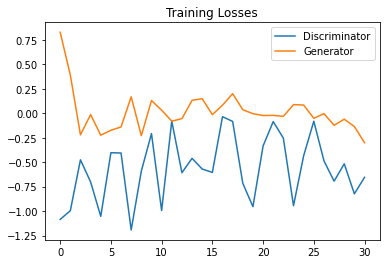

In [ ]:
fig, ax = plt.subplots()
closses = np.array(closses)
plt.plot(closses.T[0], label='Discriminator')
plt.plot(closses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:
closses
diff=[]
for i in range(0,len(closses)):
   a=closses[i][1]-closses[i][0]
   a=abs(a)
   diff.append(a)
op=sorted(diff)


In [ ]:
op

[0.09659700095653534,
 0.12463545799255371,
 0.24482417106628418,
 0.28839215636253357,
 0.3587442934513092,
 0.3720989525318146,
 0.41357529163360596,
 0.4211329370737076,
 0.4354497343301773,
 0.4395047426223755,
 0.44158054888248444,
 0.46089279651641846,
 0.46265174448490143,
 0.47144365310668945,
 0.47284311056137085,
 0.4817436784505844,
 0.5079982653260231,
 0.5240113288164139,
 0.5257575511932373,
 0.5506538450717926,
 0.5682858228683472,
 0.5685016065835953,
 0.5725068151950836,
 0.5768142938613892,
 0.5823284685611725,
 0.592748761177063,
 0.6115209758281708,
 0.6184952259063721,
 0.6221870481967926,
 0.6231763064861298,
 0.6254324913024902,
 0.6294346153736115,
 0.6320593804121017,
 0.6551158726215363,
 0.6638221442699432,
 0.67095547914505,
 0.6726415455341339,
 0.6814155280590057,
 0.6821343079209328,
 0.6839759349822998,
 0.6894636154174805,
 0.6912199258804321,
 0.6956902146339417,
 0.7066705971956253,
 0.7249656617641449,
 0.7433286607265472,
 0.7570395171642303,
 0.757

In [ ]:
for index, value in zip(range(len(diff)), diff):
    print (index, value)

0 2.8394510746002197
1 2.021526575088501
2 0.5725068151950836
3 0.6115209758281708
4 0.09659700095653534
5 1.1666499078273773
6 0.4395047426223755
7 1.361605942249298
8 0.9551376700401306
9 1.361514925956726
10 0.7650071680545807
11 1.2780224680900574
12 1.3432791233062744
13 1.1186171770095825
14 0.4817436784505844
15 1.557351529598236
16 1.2903748452663422
17 0.6726415455341339
18 0.47284311056137085
19 1.3958690762519836
20 0.7249656617641449
21 0.8481453061103821
22 0.47144365310668945
23 0.3720989525318146
24 0.8104860782623291
25 1.0235444903373718
26 0.5240113288164139
27 0.913123607635498
28 0.24482417106628418
29 0.7066705971956253
30 0.46265174448490143
31 0.12463545799255371
32 0.6551158726215363
33 0.8154922425746918
34 0.7433286607265472
35 0.592748761177063
36 0.8073693513870239
37 0.8333633840084076
38 0.5257575511932373
39 0.4211329370737076
40 0.6254324913024902
41 0.3587442934513092
42 0.4354497343301773
43 0.6839759349822998
44 0.5768142938613892
45 0.67095547914505


In [ ]:
diff.index(0.12463545799255371)

 
 


31

In [ ]:
noise = torch.randn(int(6000), z_size).to(device)
fake = gen(noise)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
fake.size()

torch.Size([6000, 14])

In [ ]:
sample_res = pd.DataFrame(fake.cpu().detach().numpy(), columns=mycols)
sample_res

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14
0,0.0,0.648734,9.999539e-01,0.0,0.0,9.291685e-01,1.643096e-04,2.650997e-11,4.902159e-07,0.0,0.0,1.588308e-08,7.756766e-10,5.769773e-06
1,0.0,0.000007,1.000000e+00,0.0,0.0,4.276538e-08,1.313929e-11,1.095160e-15,7.018153e-18,0.0,0.0,3.738593e-07,4.150720e-04,1.296574e-04
2,0.0,1.000000,2.011556e-04,0.0,0.0,1.757183e-06,1.550703e-02,1.151607e-03,2.082886e-03,0.0,0.0,4.362037e-10,1.501591e-06,1.028788e-04
3,0.0,1.000000,3.037143e-01,0.0,0.0,7.980294e-03,1.264214e-07,4.582385e-06,1.719882e-07,0.0,0.0,1.195569e-07,6.944260e-06,5.329138e-03
4,0.0,1.000000,8.788173e-02,0.0,0.0,1.812682e-06,9.836427e-01,9.365065e-11,9.177579e-01,0.0,0.0,4.483199e-09,1.691782e-06,2.587088e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.332824,9.975405e-01,0.0,0.0,9.888947e-01,1.481327e-04,1.131295e-08,2.916385e-06,0.0,0.0,2.300573e-08,2.201315e-08,7.229395e-06
5996,0.0,0.002148,1.000000e+00,0.0,0.0,8.183039e-07,2.378505e-08,1.440530e-08,3.216346e-10,0.0,0.0,5.544949e-01,2.531670e-01,2.645391e-04
5997,0.0,1.000000,7.330719e-07,0.0,0.0,2.945846e-03,9.947197e-01,2.142699e-10,9.408999e-01,0.0,0.0,1.122219e-09,4.631453e-09,2.632501e-03
5998,0.0,1.000000,1.859307e-05,0.0,0.0,4.995123e-02,6.889548e-02,3.527985e-01,8.744979e-03,0.0,0.0,5.422289e-04,3.071677e-04,1.255794e-01


In [ ]:
path = "/content/drive/MyDrive/half_gan_work/datagenerated/"
sample_res.to_csv(path+"generated_probe_optimal_wgan_gp.csv",header = True,index=False)